In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
# Import and view data head
df = pd.read_csv('/Users/sterlingaesir/Documents/PyTorch for Deep Learning with Python Bootcamp/PYTORCH_NOTEBOOKS/Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
# Descriptive Statistics
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [4]:
# Haversine Distance Formula
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
# Creates new column with distance calculations
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [6]:
# Creates data and time columns
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [7]:
# Earliest date in dataset
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [8]:
# Last date in dataset
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [10]:
# Separates categorical from continuous columns
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

In [11]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [12]:
# Combines the three categorical columns into one input array
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [13]:
# Converts categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [14]:
# Converts continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [15]:
# Converts labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [16]:
# Sets the embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [17]:
# Defining a Tabular Model

In [18]:
# This is our source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [19]:
# This is passed in when the model is instantiated
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [20]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [21]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [22]:
# Executes inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-0.0429,  1.3774, -0.9989, -0.3069, -0.1276,  0.5147,  1.6586,  0.9065,
           0.8944,  1.6238,  0.6973,  1.0540],
         [ 0.6253, -1.0524, -2.7044, -0.5079, -0.0696,  1.2952, -0.9130,  0.1796,
          -0.7773,  0.6278, -0.6167, -0.2154],
         [-2.1312,  0.2853,  0.4324,  0.0122,  0.3144,  1.5037,  1.9505, -0.4952,
          -0.9962,  0.9775,  0.9273, -0.9941],
         [ 0.2986,  1.7305, -1.1739,  1.3651,  0.7974,  0.3478, -0.3311, -0.4985,
           0.9730,  1.0700,  0.9908, -0.3709]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.4840],
         [-0.4840],
         [-0.4840],
         [ 0.4606]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.8336,  0.8049,  0.3366,  0.6341],
         [-0.3152,  0.3001, -0.2479,  2.6218],
         [-0.3152,  0.3001, -0.2479,  2.6218],
         [-1.2143, -0.5553,  1.5938, -0.4406]], grad_fn=<EmbeddingBackward0>)]

In [23]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[-0.0429,  1.3774, -0.9989, -0.3069, -0.1276,  0.5147,  1.6586,  0.9065,
          0.8944,  1.6238,  0.6973,  1.0540, -0.4840,  0.8336,  0.8049,  0.3366,
          0.6341],
        [ 0.6253, -1.0524, -2.7044, -0.5079, -0.0696,  1.2952, -0.9130,  0.1796,
         -0.7773,  0.6278, -0.6167, -0.2154, -0.4840, -0.3152,  0.3001, -0.2479,
          2.6218],
        [-2.1312,  0.2853,  0.4324,  0.0122,  0.3144,  1.5037,  1.9505, -0.4952,
         -0.9962,  0.9775,  0.9273, -0.9941, -0.4840, -0.3152,  0.3001, -0.2479,
          2.6218],
        [ 0.2986,  1.7305, -1.1739,  1.3651,  0.7974,  0.3478, -0.3311, -0.4985,
          0.9730,  1.0700,  0.9908, -0.3709,  0.4606, -1.2143, -0.5553,  1.5938,
         -0.4406]], grad_fn=<CatBackward0>)

In [24]:
# Assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [25]:
z = selfembdrop(z)
z

tensor([[-0.0000,  2.2956, -0.0000, -0.5115, -0.0000,  0.8579,  0.0000,  1.5108,
          1.4906,  0.0000,  0.0000,  1.7566, -0.8066,  0.0000,  1.3415,  0.5611,
          1.0569],
        [ 0.0000, -1.7540, -4.5074, -0.8465, -0.1161,  0.0000, -0.0000,  0.2994,
         -1.2954,  1.0463, -0.0000, -0.3591, -0.8066, -0.5253,  0.5002, -0.0000,
          4.3696],
        [-3.5520,  0.0000,  0.7206,  0.0000,  0.5240,  0.0000,  3.2509, -0.8254,
         -0.0000,  0.0000,  1.5456, -0.0000, -0.0000, -0.5253,  0.5002, -0.4132,
          4.3696],
        [ 0.4976,  0.0000, -1.9565,  2.2752,  1.3291,  0.5796, -0.5518, -0.8308,
          1.6216,  0.0000,  1.6513, -0.6181,  0.0000, -2.0238, -0.0000,  2.6563,
         -0.7343]], grad_fn=<MulBackward0>)

In [26]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [27]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [28]:
# Defines a loss function and optimizer
criterion = nn.MSELoss()  # Converted to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# Train / Test split
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [30]:
len(cat_train)

48000

In [31]:
len(cat_test)

12000

In [32]:
# Training the model w/ time counter
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.56904697
epoch:  26  loss: 10.90543461
epoch:  51  loss: 10.22923279
epoch:  76  loss: 9.74736691
epoch: 101  loss: 9.19731140
epoch: 126  loss: 8.42094898
epoch: 151  loss: 7.40506172
epoch: 176  loss: 6.24209452
epoch: 201  loss: 5.04098797
epoch: 226  loss: 4.22805834
epoch: 251  loss: 3.88569784
epoch: 276  loss: 3.75269461
epoch: 300  loss: 3.72213387

Duration: 80 seconds


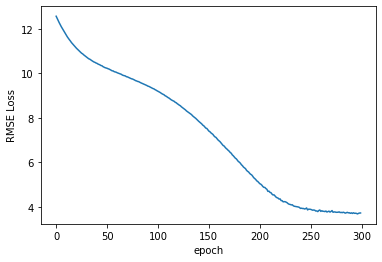

In [33]:
# Loss function plot
losses1 = [ loss.detach().numpy() for loss in losses]
plt.plot(range(epochs), losses1)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [34]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.62144327


In [35]:
# First 50 predictions
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.2074   2.9000   1.3074
 2.  14.6517   5.7000   8.9517
 3.   7.1230   7.7000   0.5770
 4.  14.5265  12.5000   2.0265
 5.   5.8024   4.1000   1.7024
 6.   5.3763   5.3000   0.0763
 7.   4.4653   3.7000   0.7653
 8.  20.2947  14.5000   5.7947
 9.   9.7265   5.7000   4.0265
10.  12.3357  10.1000   2.2357
11.   7.9040   4.5000   3.4040
12.   1.4165   6.1000   4.6835
13.   6.6332   6.9000   0.2668
14.  10.5704  14.1000   3.5296
15.   4.8328   4.5000   0.3328
16.  31.9384  34.1000   2.1616
17.   1.2216  12.5000  11.2784
18.   6.0022   4.1000   1.9022
19.   7.1538   8.5000   1.3462
20.   4.1430   5.3000   1.1570
21.  14.8266  11.3000   3.5266
22.   9.5634  10.5000   0.9366
23.  17.2487  15.3000   1.9487
24.  16.5402  14.9000   1.6402
25.  46.2277  49.5700   3.3423
26.   1.9375   5.3000   3.3625
27.   4.7619   3.7000   1.0619
28.   4.6802   6.5000   1.8198
29.  14.4922  14.1000   0.3922
30.   6.3719   4.9000   1.4719
31.   4.5083   3.7000   0.8083
32.  31.